In [1]:
from skimage.color import gray2rgb, rgb2gray

try:
    from skimage.util.montage import montage2d
except ImportError as e:
    print('scikit-image is too new, ',e)
    from skimage.util import montage as montage2d

from sklearn.datasets import fetch_olivetti_faces

import numpy as np
import matplotlib.pyplot as plt

scikit-image is too new,  No module named 'skimage.util.montage'


In [2]:
faces = fetch_olivetti_faces()

# convert the image channels from rgb to gray, so that LIME could process the images
X_vec = np.stack([gray2rgb(iimg) for iimg in faces.data.reshape((-1, 64, 64))], 0)

In [3]:
Y_vec = faces.target.astype(np.uint8)

(-0.5, 1279.5, 1279.5, -0.5)

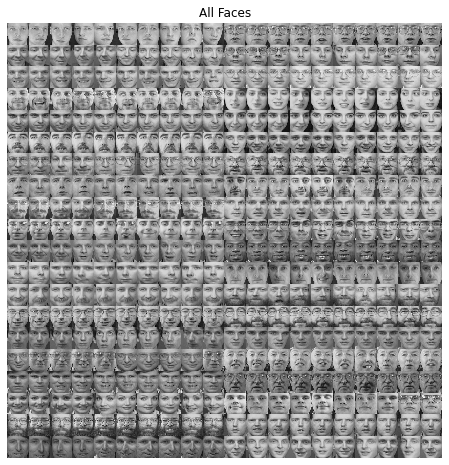

In [4]:
%matplotlib inline

fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))
ax1.imshow(montage2d(X_vec[:,:,:,0]), cmap='gray', interpolation='none')
ax1.set_title('All Faces')
ax1.axis('off')

In [5]:
Y_vec

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

(-0.5, 63.5, 63.5, -0.5)

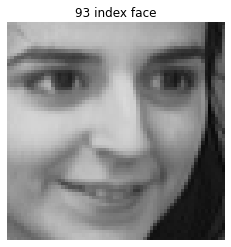

In [6]:
index = 93
plt.imshow(X_vec[index], cmap='gray')
plt.title('93 index face')
plt.axis('off')

## Training model

In [7]:
def predict_proba(image):
    return session.run(model_predict, feed_dict={ preprocessed_image: image })

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_vec, Y_vec, train_size=0.70)

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.neural_network import MLPClassifier


class PipeStep(object):
    def __init__(self, step_func):
        self._step_func = step_func

    def fit(self, *args):
        return self
    
    def transform(self, X):
        return self._step_func(X)


makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_pipeline = Pipeline([('Make Gray', makegray_step), ('Flatten Image', flatten_step), ('Normalize', Normalizer()), ('MLP', MLPClassifier( activation='relu', alpha=1e-7, epsilon=1e-6, hidden_layer_sizes=(800, 120), random_state=1))])

In [10]:
simple_pipeline.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Pipeline(memory=None,
         steps=[('Make Gray', <__main__.PipeStep object at 0x7fd8ab54b2e8>),
                ('Flatten Image', <__main__.PipeStep object at 0x7fd8ab54b240>),
                ('Normalize', Normalizer(copy=True, norm='l2')),
                ('MLP',
                 MLPClassifier(activation='relu', alpha=1e-07,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-06,
                               hidden_layer_sizes=(800, 120),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_fun=15000,
                               max_iter=200, momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=1, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=F

In [11]:
pipe_pred_test = simple_pipeline.predict(X_test)
pipe_pred_prop = simple_pipeline.predict_proba(X_test)

In [12]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_test, y_pred=pipe_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      0.33      0.50         3
           3       1.00      0.75      0.86         4
           4       0.20      1.00      0.33         1
           5       0.80      1.00      0.89         4
           6       0.67      0.67      0.67         3
           8       0.80      1.00      0.89         4
           9       0.60      1.00      0.75         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      0.50      0.67         2
          13       1.00      1.00      1.00         6
          14       0.60      1.00      0.75         3
          15       0.83      1.00      0.91         5
          16       0.75      1.00      0.86         3
          17       0.75      1.00      0.86         3
          18       0.80    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
!pip3 install lime

In [14]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm


explainer = lime_image.LimeImageExplainer()

# image segmentation algorithm: quickshift (default), slic, felzenszwalb
segmenter = SegmentationAlgorithm('slic', n_segments=100, compactness=1, sigma=1)

In [15]:
%%time

olivetti_test_index = 0
exp = explainer.explain_instance(X_test[olivetti_test_index], classifier_fn=simple_pipeline.predict_proba, top_labels=6, num_samples=1000, segmentation_fn=segmenter)


CPU times: user 2.87 s, sys: 805 ms, total: 3.68 s
Wall time: 2.04 s


Text(0.5, 1.0, 'show mask only')

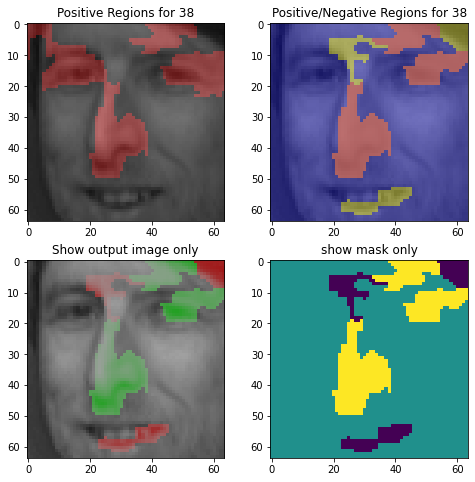

In [16]:
from skimage.color import label2rgb

# canvas setting
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8))


# visualise the segments that are not helpful for inference
temp, mask = exp.get_image_and_mask(y_test[olivetti_test_index], positive_only=True, num_features=8, hide_rest=False)

ax1.imshow(label2rgb(mask, temp, bg_label=0), interpolation='nearest')
ax1.set_title('Positive Regions for {}'.format(y_test[olivetti_test_index]))


# visualise all segments
temp, mask = exp.get_image_and_mask(y_test[olivetti_test_index], positive_only=False, num_features=8, hide_rest=False)

ax2.imshow(label2rgb(4 - mask, temp, bg_label=0), interpolation='nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test[olivetti_test_index]))


# Visualise image only
ax3.imshow(temp, interpolation='nearest')
ax3.set_title('Show output image only')


# Visualise mask only
ax4.imshow(mask, interpolation='nearest')
ax4.set_title('show mask only')

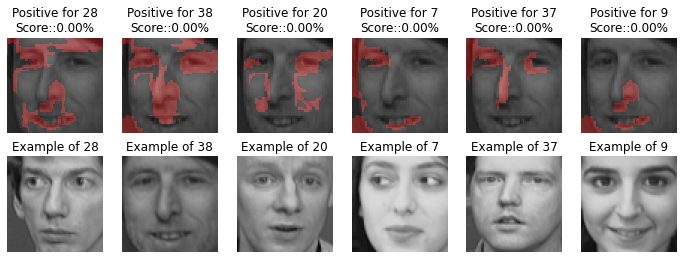

In [17]:
olivetti_test_index = 1

fig, m_axs = plt.subplots(2, 6, figsize=(12, 4))
for i, (c_ax, gt_ax) in zip(exp.top_labels, m_axs.T):
    temp, mask = exp.get_image_and_mask(i, positive_only=True, num_features=12, hide_rest=False, min_weight=0.001)

    c_ax.imshow(label2rgb(mask, temp, bg_label=0), interpolation='nearest')
    c_ax.set_title('Positive for {}\nScore::{:2.2f}%'.format(i, 100 * pipe_pred_prop[olivetti_test_index, i]))
    c_ax.axis('off')

    face_id = np.random.choice(np.where(y_train==i)[0])

    gt_ax.imshow(X_train[face_id])
    gt_ax.set_title('Example of {}'.format(i))
    gt_ax.axis('off')
